In [24]:
import pandas as pd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import structure_score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch, MaximumLikelihoodEstimator, BicScore

In [13]:
df = pd.read_csv("diabetes_data.csv")
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")] 
df.rename(columns={'sugar>7g': 'sugar', 'fatty liver': 'fatty_liver'}, inplace=True)
df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

print(df.columns)


Index(['exercise', 'BMI', 'sugar', 'fatty_liver', 'anxiety', 'diabetes'], dtype='object')


C:\Users\jjjia\AppData\Local\Temp\ipykernel_24796\3509399265.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


# Problem1

In [14]:
model = BayesianNetwork([('BMI', 'diabetes'),
                         ('sugar', 'diabetes')])

model.fit(df, estimator=MaximumLikelihoodEstimator)

for cpd in model.get_cpds():
    print(f"\nCPD of {cpd.variable}:\n", cpd)


CPD of BMI:
 +-------------+--------+
| BMI(high)   | 0.2677 |
+-------------+--------+
| BMI(low)    | 0.4149 |
+-------------+--------+
| BMI(medium) | 0.3174 |
+-------------+--------+

CPD of diabetes:
 +---------------+-----+--------------------+
| BMI           | ... | BMI(medium)        |
+---------------+-----+--------------------+
| sugar         | ... | sugar(yes)         |
+---------------+-----+--------------------+
| diabetes(no)  | ... | 0.5542771385692846 |
+---------------+-----+--------------------+
| diabetes(yes) | ... | 0.4457228614307154 |
+---------------+-----+--------------------+

CPD of sugar:
 +------------+--------+
| sugar(no)  | 0.3949 |
+------------+--------+
| sugar(yes) | 0.6051 |
+------------+--------+


In [15]:
infer = VariableElimination(model)
posterior = infer.query(variables=['sugar'], evidence={'diabetes': 'yes'})
print(posterior)

p_yes = float(posterior.values[posterior.state_names['sugar'].index('yes')])
print("\nP(sugar=yes | diabetes=yes) =", round(p_yes, 3))

+------------+--------------+
| sugar      |   phi(sugar) |
+============+==============+
| sugar(no)  |       0.4087 |
+------------+--------------+
| sugar(yes) |       0.5913 |
+------------+--------------+

P(sugar=yes | diabetes=yes) = 0.591


# Problem2

In [16]:
train = df.sample(frac=0.8, random_state=42)
valid = df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

train.shape, valid.shape, train.head(3)

((8000, 6),
 (2000, 6),
   exercise     BMI sugar fatty_liver anxiety diabetes
 0      low    high   yes        high    high       no
 1   medium  medium   yes        high     low       no
 2     high     low    no         low    high      yes)

In [17]:
def fit_and_show(edges, data, title):
    model = BayesianNetwork(list(edges))
    model.fit(data, estimator=MaximumLikelihoodEstimator)
    print(f"\n=== {title} ===")
    print("Edges:", sorted(model.edges()))
    for cpd in model.get_cpds():
        print(f"\nCPD of {cpd.variable}:\n{cpd}")
    return model

In [18]:
def draw_bn_simple(model, title, save_path=None):
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        arrows=True,
        node_size=1600,
        font_size=11
    )
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
C:\Users\jjjia\AppData\Local\Temp\ipykernel_24796\146439032.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



=== PC Learned Model ===
Edges: [('BMI', 'anxiety'), ('BMI', 'fatty_liver'), ('anxiety', 'diabetes'), ('exercise', 'BMI'), ('fatty_liver', 'diabetes'), ('sugar', 'BMI')]

CPD of sugar:
+------------+----------+
| sugar(no)  | 0.395125 |
+------------+----------+
| sugar(yes) | 0.604875 |
+------------+----------+

CPD of BMI:
+-------------+---------------------+-----+---------------------+
| exercise    | exercise(high)      | ... | exercise(medium)    |
+-------------+---------------------+-----+---------------------+
| sugar       | sugar(no)           | ... | sugar(yes)          |
+-------------+---------------------+-----+---------------------+
| BMI(high)   | 0.0                 | ... | 0.39824120603015073 |
+-------------+---------------------+-----+---------------------+
| BMI(low)    | 0.8066666666666666  | ... | 0.29564489112227804 |
+-------------+---------------------+-----+---------------------+
| BMI(medium) | 0.19333333333333333 | ... | 0.3061139028475712  |
+----------

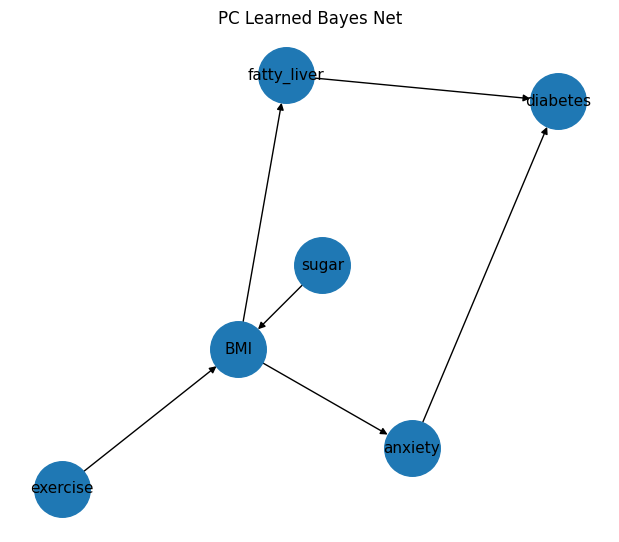

  0%|          | 8/1000000 [00:00<6:16:30, 44.27it/s] 



=== Hill-Climb (BIC Score) Learned Model ===
Edges: [('BMI', 'exercise'), ('BMI', 'sugar'), ('anxiety', 'BMI'), ('diabetes', 'anxiety'), ('fatty_liver', 'BMI'), ('fatty_liver', 'anxiety'), ('fatty_liver', 'diabetes'), ('sugar', 'exercise')]

CPD of BMI:
+-------------+---------------------+-----+----------------------+
| anxiety     | anxiety(high)       | ... | anxiety(low)         |
+-------------+---------------------+-----+----------------------+
| fatty_liver | fatty_liver(high)   | ... | fatty_liver(low)     |
+-------------+---------------------+-----+----------------------+
| BMI(high)   | 0.6139088729016786  | ... | 0.018541409147095178 |
+-------------+---------------------+-----+----------------------+
| BMI(low)    | 0.07274180655475619 | ... | 0.780799340749897    |
+-------------+---------------------+-----+----------------------+
| BMI(medium) | 0.3133493205435651  | ... | 0.20065925010300784  |
+-------------+---------------------+-----+----------------------+

CPD of 

C:\Users\jjjia\AppData\Local\Temp\ipykernel_24796\146439032.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


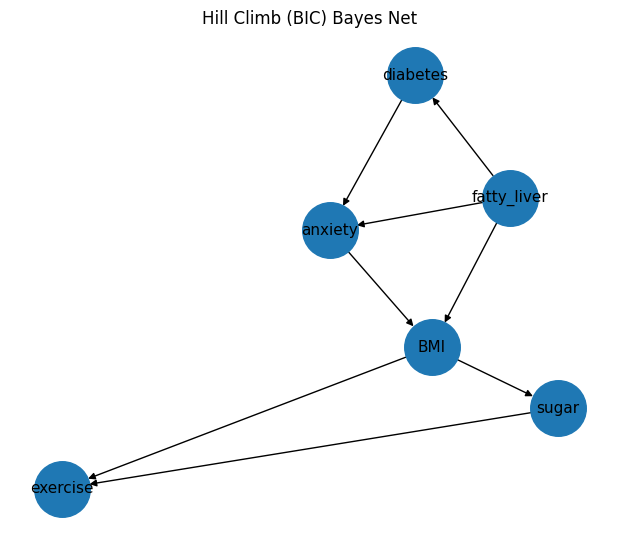

Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 9257.59it/s]



=== Tree Search (Chow–Liu) Learned Model ===
Edges: [('BMI', 'anxiety'), ('BMI', 'exercise'), ('BMI', 'sugar'), ('anxiety', 'diabetes'), ('diabetes', 'fatty_liver')]

CPD of BMI:
+-------------+---------+
| BMI(high)   | 0.26675 |
+-------------+---------+
| BMI(low)    | 0.41875 |
+-------------+---------+
| BMI(medium) | 0.3145  |
+-------------+---------+

CPD of anxiety:
+---------------+--------------------+--------------------+--------------------+
| BMI           | BMI(high)          | BMI(low)           | BMI(medium)        |
+---------------+--------------------+--------------------+--------------------+
| anxiety(high) | 0.8992502343017807 | 0.1925373134328358 | 0.6057233704292527 |
+---------------+--------------------+--------------------+--------------------+
| anxiety(low)  | 0.1007497656982193 | 0.8074626865671641 | 0.3942766295707472 |
+---------------+--------------------+--------------------+--------------------+

CPD of sugar:
+------------+---------------------+---

C:\Users\jjjia\AppData\Local\Temp\ipykernel_24796\146439032.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


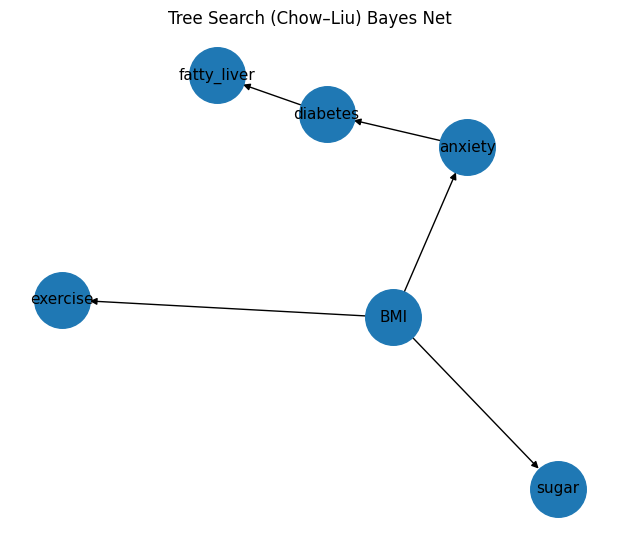

In [25]:
pc = PC(train)
pc_dag = pc.estimate(ci_test='chi_square', variant='stable', return_type='dag')
model_pc = fit_and_show(pc_dag.edges(), train, "PC Learned Model")
draw_bn_simple(model_pc, "PC Learned Bayes Net")

hc = HillClimbSearch(train)
hc_dag = hc.estimate(scoring_method=BicScore(train))
model_hc = fit_and_show(hc_dag.edges(), train, "Hill-Climb (BIC Score) Learned Model")
draw_bn_simple(model_hc, "Hill Climb (BIC) Bayes Net")

ts = TreeSearch(train)
ts_dag = ts.estimate()
model_ts = fit_and_show(ts_dag.edges(), train, "Tree Search (Chow–Liu) Learned Model")
draw_bn_simple(model_ts, "Tree Search (Chow–Liu) Bayes Net")

# Problem3

In [20]:
bic_pc = structure_score(model=model_pc, data=valid, scoring_method="bic")
bic_hc = structure_score(model=model_hc, data=valid, scoring_method="bic")
bic_ts = structure_score(model=model_ts, data=valid, scoring_method="bic")

print("BIC scores on validation data (larger is better):")
print(f"PC Model       : {bic_pc}")
print(f"Hill-Climb     : {bic_hc}")
print(f"Tree (Chow–Liu): {bic_ts}")

best_name, best_score = max(
    [("PC", bic_pc), ("Hill-Climb", bic_hc), ("Tree", bic_ts)],
    key=lambda x: x[1]
)
print("\nBest model by BIC:", best_name)

BIC scores on validation data (larger is better):
PC Model       : -8657.28800283577
Hill-Climb     : -8673.581718421672
Tree (Chow–Liu): -8784.88429145291

Best model by BIC: PC


# Problem4

In [21]:
for var in ["exercise", "sugar", "anxiety", "diabetes"]:
    cpd = model_pc.get_cpds(var)
    print(f"{var}: {cpd.state_names[var]}")

exercise: ['high', 'low', 'medium']
sugar: ['no', 'yes']
anxiety: ['high', 'low']
diabetes: ['no', 'yes']


In [22]:
infer = VariableElimination(model_pc)

EX_LOW, EX_HIGH = "low", "high"         
SG_LOW, SG_HIGH = "no", "yes"           
ANX_POS = "high"                        
DIA_POS = "yes"   

def p_at(var, state, evidence=None):
    q = infer.query(variables=[var], evidence=evidence or {})
    return float(q.values[q.state_names[var].index(state)])

def pct(x): return f"{x*100:.2f}%"

p_anx_low  = p_at("anxiety", ANX_POS, {"exercise": EX_LOW})
p_anx_high = p_at("anxiety", ANX_POS, {"exercise": EX_HIGH})
abs_red = p_anx_low - p_anx_high
rel_red = abs_red / p_anx_low if p_anx_low > 0 else float("nan")

print("Q4(a) Exercise low → high >> anxiety ")
print(f"  P(anxiety={ANX_POS} | exercise={EX_LOW} ) = {pct(p_anx_low)}")
print(f"  P(anxiety={ANX_POS} | exercise={EX_HIGH}) = {pct(p_anx_high)}")
print(f"  Absolute reduction: {pct(abs_red)}")
print(f"  Relative reduction: {rel_red*100:.2f}%")

Q4(a) Exercise low → high >> anxiety 
  P(anxiety=high | exercise=low ) = 59.37%
  P(anxiety=high | exercise=high) = 37.85%
  Absolute reduction: 21.52%
  Relative reduction: 36.25%


In [23]:
p_anx_sg_low  = p_at("anxiety",  ANX_POS, {"sugar": SG_LOW})
p_anx_sg_high = p_at("anxiety",  ANX_POS, {"sugar": SG_HIGH})
p_dia_sg_low  = p_at("diabetes", DIA_POS, {"sugar": SG_LOW})
p_dia_sg_high = p_at("diabetes", DIA_POS, {"sugar": SG_HIGH})

print("\nQ4(b) Sugar no → yes ")
print("  Anxiety:")
print(f"    P(anxiety={ANX_POS} | sugar={SG_LOW} ) = {pct(p_anx_sg_low)}")
print(f"    P(anxiety={ANX_POS} | sugar={SG_HIGH}) = {pct(p_anx_sg_high)}")
print(f"    Absolute change: {pct(p_anx_sg_high - p_anx_sg_low)}")

print("  Diabetes:")
print(f"    P(diabetes={DIA_POS} | sugar={SG_LOW} ) = {pct(p_dia_sg_low)}")
print(f"    P(diabetes={DIA_POS} | sugar={SG_HIGH}) = {pct(p_dia_sg_high)}")
print(f"    Absolute change: {pct(p_dia_sg_high - p_dia_sg_low)}")


Q4(b) Sugar no → yes 
  Anxiety:
    P(anxiety=high | sugar=no ) = 37.08%
    P(anxiety=high | sugar=yes) = 60.33%
    Absolute change: 23.25%
  Diabetes:
    P(diabetes=yes | sugar=no ) = 34.67%
    P(diabetes=yes | sugar=yes) = 48.72%
    Absolute change: 14.05%
